In [ ]:
!pip install pyLDAvis
!pip install --upgrade gensim

import nltk

# !wget https://github.com/alexjercan/asr-toolkit/releases/download/v1.0/data.zip -O tmp.zip
# !unzip -q tmp.zip -d ./ && rm tmp.zip

# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip -O tmp.zip
# !unzip -q tmp.zip -d ./ && rm tmp.zip

nltk.download('all')

!pip install -U spacy
!python -m spacy download en_core_web_sm

In [ ]:
import os
import re

import urllib.request
from functools import partial
from itertools import islice
from collections import Counter

import spacy
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, names
from nltk.corpus import wordnet

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.hdpmodel import HdpModel
from gensim.models import CoherenceModel, KeyedVectors, Word2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import gensim.downloader as api

import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models

SEED = 42

dataroot = os.path.join(".")

pyLDAvis_outpath = os.path.join(dataroot, "view", "data.html")
id2word_outpath = os.path.join(dataroot, "models", "id2word.dict")
optimal_model_outpath = os.path.join(dataroot, "models", "lda_model.model")
extra_stopwords_url = "https://raw.githubusercontent.com/adjidieng/ETM/master/scripts/stops.txt"
word2vec_vec_url = "https://raw.githubusercontent.com/iamyuanchung/speech2vec-pretrained-vectors/master/speech2vec/300.vec"

os.makedirs(os.path.join(dataroot, "view"), exist_ok=True)
os.makedirs(os.path.join(dataroot, "models"), exist_ok=True)

In [ ]:
# The csv files containing the data
train_clean_100_path = os.path.join(dataroot, "data", "train-clean-100.csv")
train_clean_360_path = os.path.join(dataroot, "data", "train-clean-360.csv")
dev_clean_path = os.path.join(dataroot, "data", "dev-clean.csv")
test_clean_path = os.path.join(dataroot, "data", "test-clean.csv")
dev_other_path = os.path.join(dataroot, "data", "dev-other.csv")
test_other_path = os.path.join(dataroot, "data", "test-other.csv")

# Read the csv files
train_df = pd.read_csv(train_clean_100_path, index_col=0)
train_df_2 = pd.read_csv(train_clean_360_path, index_col=0)
dev_df = pd.read_csv(dev_clean_path, index_col=0)
test_df = pd.read_csv(test_clean_path, index_col=0)
dev_df_2 = pd.read_csv(dev_other_path, index_col=0)
test_df_2 = pd.read_csv(test_other_path, index_col=0)

train_df_2 =  pd.DataFrame({"TEXT": train_df_2["REAL TEXT"], "BOOK": train_df_2["BOOK TITLE"], "DURATION": train_df_2["DURATION"]})
train_df =  pd.DataFrame({"TEXT": train_df["REAL TEXT"], "BOOK": train_df["BOOK TITLE"], "DURATION": train_df["DURATION"]})
dev_df = pd.DataFrame({"TEXT": dev_df["TEXT"], "BOOK": dev_df["BOOK TITLE"], "DURATION": dev_df["DURATION"]})
test_df = pd.DataFrame({"TEXT": test_df["TEXT"], "BOOK": test_df["BOOK TITLE"], "DURATION": test_df["DURATION"]})
dev_df_2 = pd.DataFrame({"TEXT": dev_df_2["REAL TEXT"], "BOOK": dev_df_2["BOOK TITLE"], "DURATION": dev_df_2["DURATION"]})
test_df_2 = pd.DataFrame({"TEXT": test_df_2["REAL TEXT"], "BOOK": test_df_2["BOOK TITLE"], "DURATION": test_df_2["DURATION"]})

# Merge data in one dataframe
book_df = pd.concat([train_df, train_df_2, dev_df, test_df, dev_df_2, test_df_2]).reset_index(drop=True)

class WikipediaCorpus:
    def __init__(self, k=100):
        self.dataset = iter(api.load('wiki-english-20171001'))
        self.k = k

    def __iter__(self):
        for article in list(islice(self.dataset, self.k)):
            yield list(filter(str.isalpha, word_tokenize("".join(article['section_texts']).lower())))

# sentences = WikipediaCorpus(10_000)

# wiki_df = pd.DataFrame({'TEXT': list(iter(sentences))})

# Now we can see we have the content of the book, the title and the duration
book_df.head()

,TEXT,BOOK,DURATION
0,TILL THEY WOULD FINALLY CIRCLE ROUND AND ROUND...,"The Life of Hon. William F. Cody, Known as Buf...",17.67
1,AS CINCINNATUS OR CORNELIA NOW TO SUCH A QUIET...,"Divine Comedy, Longfellow's Translation, Complete",25.10
2,LOUISE AND BETH HAVING AT LAST FULL KNOWLEDGE ...,Aunt Jane's Nieces,17.11
3,MODE BEARD THE OYSTERS AND SCALD THEM IN THEIR...,The Book of Household Management,5.79
4,SHE SAID SHE WAS NOT ABSOLUTELY CERTAIN OF THE...,The Professor,7.95


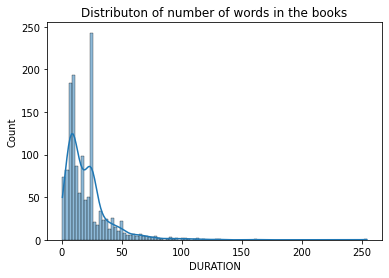

,DURATION
count,1397.000000
mean,20.798239
std,19.099790
min,0.540000
25%,8.230000
50%,16.350000
75%,25.150000
max,254.310000


In [ ]:
# Lets seee the distribution of the lengths of each sample book
# sns.histplot(wiki_df['TEXT'].apply(len), kde=True, bins=100)
# plt.title("Distributon of number of words in the article")
# plt.show()
# wiki_df['TEXT'].apply(len).describe()
sns.histplot(book_df, x='DURATION', kde=True, bins=100)
plt.title("Distributon of number of words in the books")
plt.show()
book_df.describe()

In [ ]:
# First lets remove the books that are too long or too short from our data using the z score
# wiki_df = wiki_df[wiki_df['TEXT'].apply(len) >= 1000]
# wiki_df = wiki_df[(np.abs(stats.zscore(wiki_df['TEXT'].apply(len))) < 3)]

# wiki_df.head()
book_df = book_df[book_df['DURATION'] > 30]
# book_df = book_df[(np.abs(stats.zscore(book_df['DURATION'])) < 3)]
book_df = book_df.reset_index(drop=True)

book_df.head()

,TEXT,BOOK,DURATION
0,BUT STILL VISIBLE ON THE OPPOSITE CORNER OF TH...,"The Life and Opinions of Tristram Shandy, Gent...",41.87
1,WHEN SHE RECOGNIZED HER LOVER THE POOR GIRL EX...,The Count of Monte Cristo,112.33
2,WITHOUT HAVING SEEN ONE AMIABLE YOUTH WHO COUL...,Northanger Abbey,80.36
3,AND ENDED REMOTELY IN A RAILED SPACE LIKE A BA...,The Sleeper Awakes A Revised Edition of When t...,35.35
4,THE WATCH OF A SHIP WHICH HAS WANDERED FROM HE...,The Man Who Laughs,90.57


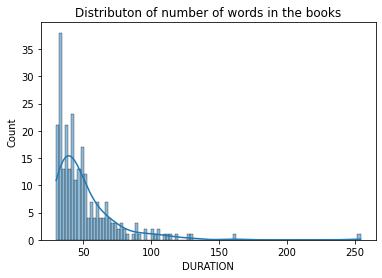

,DURATION
count,257.000000
mean,50.895019
std,24.408834
min,30.020000
25%,35.220000
50%,43.460000
75%,56.620000
max,254.310000


In [ ]:
# # Lets seee the distribution of the lengths of each sample book
# sns.histplot(wiki_df['TEXT'].apply(len), kde=True, bins=100)
# plt.title("Distributon of number of words in the article")
# plt.show()
# wiki_df['TEXT'].apply(len).describe()
sns.histplot(book_df, x='DURATION', kde=True, bins=100)
plt.title("Distributon of number of words in the books")
plt.show()
book_df.describe()

In [ ]:
# Now lets convert each string to lower case
book_df['TEXT'] = book_df['TEXT'].apply(str.lower)
book_df.head()

,TEXT,BOOK,DURATION
0,but still visible on the opposite corner of th...,"The Life and Opinions of Tristram Shandy, Gent...",41.87
1,when she recognized her lover the poor girl ex...,The Count of Monte Cristo,112.33
2,without having seen one amiable youth who coul...,Northanger Abbey,80.36
3,and ended remotely in a railed space like a ba...,The Sleeper Awakes A Revised Edition of When t...,35.35
4,the watch of a ship which has wandered from he...,The Man Who Laughs,90.57


In [ ]:
# Now lets decontract words that contain "'"
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontract(phrase: str):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

book_df['TEXT'] = book_df['TEXT'].apply(decontract)
book_df.head()

,TEXT,BOOK,DURATION
0,but still visible on the opposite corner of th...,"The Life and Opinions of Tristram Shandy, Gent...",41.87
1,when she recognized her lover the poor girl ex...,The Count of Monte Cristo,112.33
2,without having seen one amiable youth who coul...,Northanger Abbey,80.36
3,and ended remotely in a railed space like a ba...,The Sleeper Awakes A Revised Edition of When t...,35.35
4,the watch of a ship which has wandered from he...,The Man Who Laughs,90.57


In [ ]:
# Now lets tokanize the text string into a list of words
book_df['TEXT'] = book_df['TEXT'].apply(word_tokenize)
book_df.head()

,TEXT,BOOK,DURATION
0,"[but, still, visible, on, the, opposite, corne...","The Life and Opinions of Tristram Shandy, Gent...",41.87
1,"[when, she, recognized, her, lover, the, poor,...",The Count of Monte Cristo,112.33
2,"[without, having, seen, one, amiable, youth, w...",Northanger Abbey,80.36
3,"[and, ended, remotely, in, a, railed, space, l...",The Sleeper Awakes A Revised Edition of When t...,35.35
4,"[the, watch, of, a, ship, which, has, wandered...",The Man Who Laughs,90.57


In [ ]:
# Now lets remove short words from our text
# how short is a short words
_short = 3

def is_not_short(word):
    return len(word) > _short

book_df['TEXT'] = book_df['TEXT'].apply(partial(filter, is_not_short)).apply(list)
# wiki_df['TEXT'] = wiki_df['TEXT'].apply(partial(filter, is_not_short)).apply(list)

book_df.head()

,TEXT,BOOK,DURATION
0,"[still, visible, opposite, corner, which, unqu...","The Life and Opinions of Tristram Shandy, Gent...",41.87
1,"[when, recognized, lover, poor, girl, extended...",The Count of Monte Cristo,112.33
2,"[without, having, seen, amiable, youth, could,...",Northanger Abbey,80.36
3,"[ended, remotely, railed, space, like, balcony...",The Sleeper Awakes A Revised Edition of When t...,35.35
4,"[watch, ship, which, wandered, from, course, f...",The Man Who Laughs,90.57


In [ ]:
# Now lets remove stopwords
with urllib.request.urlopen(extra_stopwords_url) as url:
    _extra_stopwords = set(url.read().decode().splitlines())
_more_stopwords = set([
    # interjections
    "oh", "ah",
    # useless
    "yes", "no",
    # archaic terms: they, you, triplet, to do, you
    "thy", "thou", "thrin", "didst", "thee",
    # other terms that appear often and dont't have any value
    "mister", "missus", "miss",
    # names
    *map(str.lower, names.words())
])
_stopwords = set(stopwords.words('english')) | _more_stopwords | _extra_stopwords

def not_in_stopwords(word):
    return word not in _stopwords

book_df['TEXT'] = book_df['TEXT'].apply(partial(filter, not_in_stopwords)).apply(list)
# wiki_df['TEXT'] = wiki_df['TEXT'].apply(partial(filter, not_in_stopwords)).apply(list)

book_df.head()

,TEXT,BOOK,DURATION
0,"[visible, opposite, corner, unquestionably, ho...","The Life and Opinions of Tristram Shandy, Gent...",41.87
1,"[recognized, lover, poor, girl, extended, arms...",The Count of Monte Cristo,112.33
2,"[amiable, youth, call, sensibility, inspired, ...",Northanger Abbey,80.36
3,"[ended, remotely, railed, space, balcony, brig...",The Sleeper Awakes A Revised Edition of When t...,35.35
4,"[watch, ship, wandered, feels, emotion, cries,...",The Man Who Laughs,90.57


In [ ]:
# Convert to other pos
WN_NOUN = 'n'
WN_VERB = 'v'
WN_ADJECTIVE = 'a'
WN_ADJECTIVE_SATELLITE = 's'
WN_ADVERB = 'r'

def convert(word, from_pos, to_pos):    
    """ Transform words given from/to POS tags """

    synsets = wordnet.synsets(word, pos=from_pos)

    # Word not found
    if not synsets:
        return []

    # Get all lemmas of the word (consider 'a'and 's' equivalent)
    lemmas = []
    for s in synsets:
        for l in s.lemmas():
            if s.name().split('.')[1] == from_pos or from_pos in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE) and s.name().split('.')[1] in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE):
                lemmas += [l]

    # Get related forms
    derivationally_related_forms = [(l, l.derivationally_related_forms()) for l in lemmas]

    # filter only the desired pos (consider 'a' and 's' equivalent)
    related_noun_lemmas = []

    for drf in derivationally_related_forms:
        for l in drf[1]:
            if l.synset().name().split('.')[1] == to_pos or to_pos in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE) and l.synset().name().split('.')[1] in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE):
                related_noun_lemmas += [l]

    # Extract the words from the lemmas
    words = [l.name() for l in related_noun_lemmas]
    len_words = len(words)

    # Build the result in the form of a list containing tuples (word, probability)
    result = [(w, float(words.count(w)) / len_words) for w in set(words)]
    result.sort(key=lambda w:-w[1])

    # return all the possibilities sorted by probability
    return result

def get_options(token, pos):
    if pos == WN_VERB:
        return convert(token, pos, WN_NOUN)
    if pos == WN_ADVERB:
        return convert(token, pos, WN_ADJECTIVE)
    if pos == WN_ADJECTIVE_SATELLITE:
        return convert(token, pos, WN_ADJECTIVE)
    return []

def convert_fn(pair, threshold=0.3):
    token, pos = pair
    pos = pos[0].lower()
    options = get_options(token, pos)
    return token if (not options or options[0][1] < threshold) else options[0][0]

def lemmatize(words):
    tokens = pos_tag(words)
    tokens = map(convert_fn, tokens)
    return list(tokens)

book_df['TEXT'] = book_df['TEXT'].apply(lemmatize)
# wiki_df['TEXT'] = wiki_df['TEXT'].apply(lemmatize)

book_df.head()

,TEXT,BOOK,DURATION
0,"[visible, opposite, corner, unquestionably, ho...","The Life and Opinions of Tristram Shandy, Gent...",41.87
1,"[acknowledgment, lover, poor, girl, extended, ...",The Count of Monte Cristo,112.33
2,"[amiable, youth, call, sensibility, inspired, ...",Northanger Abbey,80.36
3,"[end, remotely, railed, space, balcony, bright...",The Sleeper Awakes A Revised Edition of When t...,35.35
4,"[watch, ship, wandered, feels, emotion, cries,...",The Man Who Laughs,90.57


In [ ]:
# Now lets lemmatize the words to their basic form
nlp = spacy.load('en_core_web_sm')

def lemmatize(text):
    tokens = nlp(" ".join(text))
    tokens = filter(lambda tok: tok.pos_ != 'PRON', tokens)
    tokens = map(lambda tok: tok.lemma_.lower().strip(), tokens)
    return list(tokens)

book_df['TEXT'] = book_df['TEXT'].apply(lemmatize)
# wiki_df['TEXT'] = wiki_df['TEXT'].apply(lemmatize)

book_df.head()

,TEXT,BOOK,DURATION
0,"[visible, opposite, corner, unquestionably, ho...","The Life and Opinions of Tristram Shandy, Gent...",41.87
1,"[acknowledgment, lover, poor, girl, extend, ar...",The Count of Monte Cristo,112.33
2,"[amiable, youth, call, sensibility, inspire, r...",Northanger Abbey,80.36
3,"[end, remotely, rail, space, balcony, brightly...",The Sleeper Awakes A Revised Edition of When t...,35.35
4,"[watch, ship, wander, feel, emotion, cry, land...",The Man Who Laughs,90.57


In [ ]:
# Create Dictionary
id2word = Dictionary(book_df['TEXT'])

# Filter extremes, remove all words that appear in less than 4 documents
# remove all words that appear in more than 25% of the documents
id2word.filter_extremes(no_below=3, no_above=0.25)
# remove the 5000 most frequent words
id2word.filter_n_most_frequent(5_000)

# Term Document Frequency
book_corpus = [id2word.doc2bow(text) for text in book_df['TEXT']]
# wiki_corpus = [id2word.doc2bow(text) for text in wiki_df['TEXT']]

[[(id2word[id], freq) for id, freq in cp] for cp in book_corpus[:1]][0][:5]

[('aegina', 1), ('aids', 1), ('amour', 1), ('arbour', 1), ('assimilation', 1)]

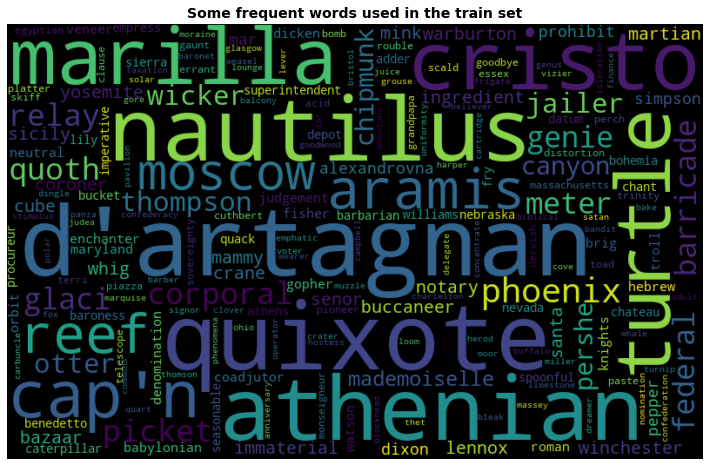

In [ ]:
# Now lets visualize a word cloud of our books
all_freq = sum([Counter({id2word[k]: freq for k, freq in cp}) for cp in book_corpus], Counter())

wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate_from_frequencies(all_freq)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the train set", weight='bold', fontsize=14)
plt.show()

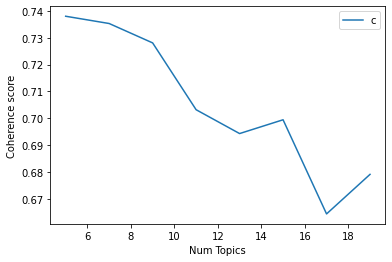

In [ ]:
coherence_values = []
model_list = []
x = range(5, 21, 2)

for num_topics in x:
    model = LdaModel(corpus=book_corpus, id2word=id2word, num_topics=num_topics)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=book_df['TEXT'], dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Show graph
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
hdp_model = HdpModel(corpus=book_corpus, id2word=id2word, K=10, T=15, random_state=SEED)
coherencemodel = CoherenceModel(model=hdp_model, texts=book_df['TEXT'], dictionary=id2word, coherence='c_v')
hdp_model_c = coherencemodel.get_coherence()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
best = np.array(coherence_values).argmax()
print(f"The best coherence value is {coherence_values[best]} for model {best}")
print(f"The coherence value for the hdpmodel is {hdp_model_c}")

lda_model_c = coherence_values[best]
lda_model = model_list[best]

num_topics = x[best] if lda_model_c > hdp_model_c else len(hdp_model.get_topics())

model_name = f"lda" if lda_model_c > hdp_model_c else "hdp"
print(f"Choosing the {model_name} model with {num_topics} topics")
optimal_model = lda_model if lda_model_c > hdp_model_c else hdp_model

# Select the model and print the topics
model_topics = optimal_model.show_topics(num_topics=num_topics, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

Num Topics = 5  has Coherence Value of 0.738
Num Topics = 7  has Coherence Value of 0.7353
Num Topics = 9  has Coherence Value of 0.7281
Num Topics = 11  has Coherence Value of 0.7032
Num Topics = 13  has Coherence Value of 0.6943
Num Topics = 15  has Coherence Value of 0.6994
Num Topics = 17  has Coherence Value of 0.6644
Num Topics = 19  has Coherence Value of 0.6791
The best coherence value is 0.7379938163789971 for model 0
The coherence value for the hdpmodel is 0.7541203261466879
Choosing the hdp model with 15 topics
[(0,
  '0.017*veranda + 0.006*submissive + 0.006*flounce + 0.004*tete + 0.004*mammy '
  '+ 0.004*soothingly + 0.004*reprove + 0.002*kindest + 0.002*sad + '
  '0.002*contrition'),
 (1,
  '0.001*hussar + 0.001*poring + 0.001*rampart + 0.001*dialect + '
  '0.001*cynicism + 0.001*betterment + 0.001*bedstead + 0.001*sabre + '
  '0.001*specifically + 0.001*partridge'),
 (2,
  '0.001*letting + 0.001*corpuscle + 0.001*surplice + 0.001*earthy + '
  '0.001*insert + 0.001*curb +

In [ ]:
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim_models.prepare(optimal_model, book_corpus, id2word)
pyLDAvis.save_html(data, pyLDAvis_outpath)
data

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3     -0.006465 -0.003027       1        1  9.613894
4     -0.013476  0.016814       2        1  8.973954
2     -0.012128  0.000279       3        1  7.935304
8     -0.018029 -0.027429       4        1  7.735769
9     -0.011626  0.046797       5        1  7.568611
11    -0.014419 -0.071977       6        1  7.223029
1     -0.012307 -0.050425       7        1  7.034897
7     -0.019822  0.028472       8        1  6.552629
6     -0.004481 -0.045862       9        1  6.041693
5     -0.007795  0.018590      10        1  6.040903
10    -0.006081  0.011794      11        1  5.743022
14    -0.011374  0.069810      12        1  5.623568
12    -0.010145  0.002219      13        1  5.469835
13    -0.016800  0.003615      14        1  4.372779
0      0.164948  0.000329      15        1  4.070114, topic_info=            Term       Freq      Total Category  logprob  loglift
1488     veranda  44.000000  44.000000  Default  30.0000  30.0000
4987  submissive  18.000000  18.000000  Default  29.0000  29.0000
5326     flounce  17.000000  17.000000  Default  28.0000  28.0000
515         tete  14.000000  14.000000  Default  27.0000  27.0000
1475  soothingly  14.000000  14.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
1236   interdict   4.570341  13.360992  Topic15  -6.1280   2.1287
934      relapse   4.495574  12.749781  Topic15  -6.1445   2.1591
2122      lounge   4.427624  11.733495  Topic15  -6.1597   2.2269
4643      danced   4.433840  13.503182  Topic15  -6.1583   2.0878
2087       gauge   4.336991  12.250546  Topic15  -6.1804   2.1631

[733 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4068      1  0.193709    aback
4068      4  0.387419    aback
4068      5  0.096855    aback
4068      8  0.096855    aback
4068     13  0.096855    aback
...     ...       ...      ...
1013      1  0.129697  zealand
1013      2  0.129697  zealand
1013      5  0.129697  zealand
1013      9  0.389090  zealand
1013     12  0.129697  zealand

[3430 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 9, 10, 12, 2, 8, 7, 6, 11, 15, 13, 14, 1])

In [ ]:
# Get the topic keywords
topic_keywords = [([word for word, prop in optimal_model.show_topic(t)]) for t in range(num_topics)]
topic_keywords_df = pd.DataFrame({'Topic_Keywords': topic_keywords})
topic_keywords_df

,Topic_Keywords
0,"[veranda, submissive, flounce, tete, mammy, so..."
1,"[hussar, poring, rampart, dialect, cynicism, b..."
2,"[letting, corpuscle, surplice, earthy, insert,..."
3,"[quixote, toothless, norfolk, nautical, windin..."
4,"[plantagenet, incredulity, aramis, discoverabl..."
5,"[egoist, fawn, infringe, nymph, underworld, un..."
6,"[irritable, utensil, zealand, intentional, man..."
7,"[unrivalled, bride, dumple, reg'lar, observato..."
8,"[athenian, earning, barricade, bug, howell, ha..."
9,"[innkeeper, undoubte, whittler, denomination, ..."


['hussar', 'poring', 'rampart', 'dialect', 'cynicism', 'betterment', 'bedstead', 'sabre', 'specifically', 'partridge', 'hermitage', 'aright', 'bulwark', 'blackguard', 'vespasian', 'evangelist', 'anterior', 'pagan', 'telegraphy', 'experimentation']
['letting', 'corpuscle', 'surplice', 'earthy', 'insert', 'curb', 'stevenson', 'invader', 'showman', 'edward', 'perennial', 'isolated', 'giddy', 'nautilus', 'moonbeam', 'alertness', 'cruise', 'winchester', 'clamour', 'impotent']
['plantagenet', 'incredulity', 'aramis', 'discoverable', 'buggy', 'courtly', 'furth', 'expound', 'winnow', 'wharve', 'amply', 'hack', 'quarrelsome', 'monotonously', 'quack', 'behead', 'missive', 'nautilus', 'flake', 'excusable']
['innkeeper', 'undoubte', 'whittler', 'denomination', 'triumphal', 'copious', 'unduly', 'noisily', 'slouch', 'nun', 'rebuild', 'hullo', 'menacingly', 'asset', 'thinkin', 'concentrated', 'puss', 'cowl', 'confided', 'tribune']


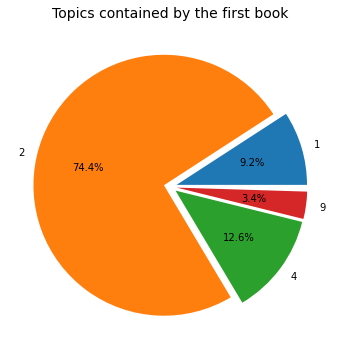

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Text,Book
0,0,2.0,"[0, 0.0916, 0.7439, 0, 0.1259, 0, 0, 0, 0, 0.0...","[visible, opposite, corner, unquestionably, ho...","The Life and Opinions of Tristram Shandy, Gent..."
1,1,6.0,"[0, 0, 0, 0.184, 0, 0.1762, 0.4401, 0.0649, 0,...","[acknowledgment, lover, poor, girl, extend, ar...",The Count of Monte Cristo
2,2,7.0,"[0.107, 0, 0, 0.1548, 0.2212, 0, 0, 0.2709, 0,...","[amiable, youth, call, sensibility, inspire, r...",Northanger Abbey
3,3,4.0,"[0, 0, 0.1051, 0, 0.3311, 0.1032, 0.0552, 0, 0...","[end, remotely, rail, space, balcony, brightly...",The Sleeper Awakes A Revised Edition of When t...
4,4,4.0,"[0.0341, 0.0622, 0.2017, 0, 0.2087, 0.0398, 0,...","[watch, ship, wander, feel, emotion, cry, land...",The Man Who Laughs
5,5,7.0,"[0.0115, 0, 0.1578, 0, 0, 0.2438, 0.1598, 0.26...","[hurst, bingley, cry, injustice, implication, ...",Pride and Prejudice
6,6,7.0,"[0.0167, 0, 0, 0.1679, 0.1202, 0.134, 0.0407, ...","[race, coachman, speak, portress, fine, stout,...",Les Miserables
7,7,10.0,"[0.209, 0, 0.1217, 0, 0, 0, 0.1027, 0.1144, 0,...","[nod, stew, head, time, emphasize, evident, ap...",Aunt Jane's Nieces Abroad
8,8,8.0,"[0, 0, 0.0928, 0.203, 0, 0, 0, 0, 0.3926, 0.15...","[hear, roar, scream, wild, beast, afraid, dark...",Buccaneers and Pirates of Our Coasts
9,9,14.0,"[0, 0.1639, 0.1152, 0.1139, 0, 0, 0.1596, 0, 0...","[phrase, follow, pause, look, toe, moment, cou...",Secret Places of the Heart


In [ ]:
# Finding the dominant topic in each book
# Init output
dominant_topic_df = pd.DataFrame()

# Get main topic in each document
for i, row in enumerate(optimal_model[book_corpus]):
    topic_num, _ = sorted(row, key=lambda x: (x[1]), reverse=True)[0]
    prop_topics = {t: round(p, 4) for t, p in row}
    prop_topics = [prop_topics.get(t, 0) for t in range(num_topics)]
    dominant_topic_df = dominant_topic_df.append(pd.Series([int(topic_num), prop_topics]), ignore_index=True)
dominant_topic_df.columns = ['Dominant_Topic', 'Perc_Contribution']

dominant_topic_df = pd.concat([dominant_topic_df,  pd.Series(book_df['TEXT'].to_list()),  pd.Series(book_df['BOOK'].to_list())], axis=1)

# Format
dominant_topic_df = dominant_topic_df.reset_index()
dominant_topic_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text', 'Book']

# Show
example_row = dominant_topic_df.iloc[0]
pie, ax = plt.subplots(figsize=[10,6])
data = {k: v for k, v in zip(list(range(num_topics)), example_row['Topic_Perc_Contrib']) if v > 0}
for k, v in data.items():
    print(topic_keywords_df['Topic_Keywords'][k])
plt.pie(x=data.values(), autopct="%.1f%%", explode=[0.05]*len(data.keys()), labels=data.keys())
plt.title("Topics contained by the first book", fontsize=14)
plt.show()

dominant_topic_df.head(10)

In [ ]:
# Find the most representative document for each topic
# Group top 5 sentences under each topic
topic_contrib_df = dominant_topic_df.copy(deep=True)
best_book_topic_df = pd.DataFrame()

for i in range(num_topics):
    bookid = dominant_topic_df['Topic_Perc_Contrib'].apply(lambda p: p[i]).argmax()
    best_book_topic_df = best_book_topic_df.append(pd.Series([i, int(bookid), dominant_topic_df['Text'][bookid], dominant_topic_df['Book'][bookid]]), ignore_index=True)

best_book_topic_df.columns = ['Topic_Num', 'Document_No', 'Text', 'Book']
best_book_topic_df

,Topic_Num,Document_No,Text,Book
0,0.0,256.0,"[model, resemble, dress, manner, copy, perfect...","Elsie's Girlhood A Sequel to ""Elsie Dinsmore"" ..."
1,1.0,240.0,"[nice, child, ask, loser, desire, sell, carpet...",The Phoenix and the Carpet
2,2.0,140.0,"[calf, liver, heart, good, broiler, fry, peopl...",The American Housewife Containing the Most Val...
3,3.0,219.0,"[look, look, empty, loom, beautiful, piece, cl...",The Yellow Fairy Book
4,4.0,176.0,"[umbrella, tuck, carefully, underneath, remark...",Sky Island Being the Further Exciting Adventur...
5,5.0,201.0,"[speck, water, look, sail, near, grown, large,...",Mother Goose in Prose
6,6.0,223.0,"[love, smile, plain, face, make, absolutely, b...",Five Little Peppers Abroad
7,7.0,226.0,"[diver, willow, lavation, root, ooze, green, p...",The Yosemite
8,8.0,227.0,"[enjoyment, freedom, tyrant, unbroken, possess...",The History of the Peloponnesian War
9,9.0,56.0,"[stop, greet, stranger, reply, calender, newly...",The Arabian Nights


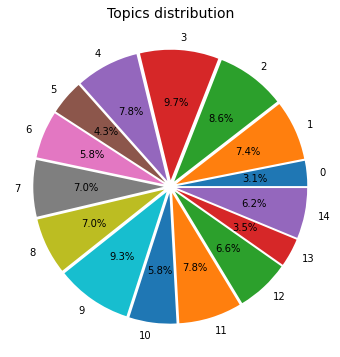

,Topic_Num,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0,"[veranda, submissive, flounce, tete, mammy, so...",8,0.0311
1.0,1,"[hussar, poring, rampart, dialect, cynicism, b...",19,0.0739
2.0,2,"[letting, corpuscle, surplice, earthy, insert,...",22,0.0856
3.0,3,"[quixote, toothless, norfolk, nautical, windin...",25,0.0973
4.0,4,"[plantagenet, incredulity, aramis, discoverabl...",20,0.0778
5.0,5,"[egoist, fawn, infringe, nymph, underworld, un...",11,0.0428
6.0,6,"[irritable, utensil, zealand, intentional, man...",15,0.0584
7.0,7,"[unrivalled, bride, dumple, reg'lar, observato...",18,0.0700
8.0,8,"[athenian, earning, barricade, bug, howell, ha...",18,0.0700
9.0,9,"[innkeeper, undoubte, whittler, denomination, ...",24,0.0934


In [ ]:
# Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = dominant_topic_df['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


# Concatenate Column wise
dominant_topics_df = pd.concat([pd.DataFrame(range(num_topics)), topic_keywords_df, topic_counts, topic_contribution], axis=1)

# Change Column names
dominant_topics_df.columns = ['Topic_Num', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
dominant_topics_df = dominant_topics_df.fillna(0)

# Show
pie, ax = plt.subplots(figsize=[10,6])
data = {k: v for k, v in zip(dominant_topics_df['Topic_Num'], dominant_topics_df['Perc_Documents']) if v > 0}
plt.pie(x=data.values(), autopct="%.1f%%", explode=[0.05]*len(data.keys()), labels=data.keys())
plt.title("Topics distribution", fontsize=14)
plt.show()

dominant_topics_df

Predicted topic for the book "None" are


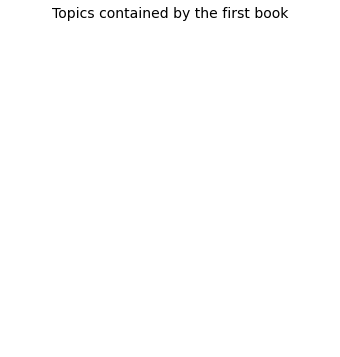

In [ ]:
# Run inference on a book example
x = word_tokenize("This is an example of how to run inference but it is a short book".lower())
x = id2word.doc2bow(x)
y_hat = optimal_model[[x]]

_threshold = 0.00
data = {k: v for k, v in y_hat[0] if v >= _threshold}
topics = sorted(data.items(), key=lambda e: e[1], reverse=True)
print(f"Predicted topic for the book \"{None}\" are")
for k, v in topics:
    print(f"{k} and contains {topic_keywords[k]} keywords.")

pie, ax = plt.subplots(figsize=[10, 6])

plt.pie(x=data.values(), autopct="%.1f%%", explode=[0.05]*len(data.keys()), labels=data.keys())
plt.title("Topics contained by the first book", fontsize=14)
plt.show()

In [ ]:
id2word.save(id2word_outpath)
optimal_model.save(optimal_model_outpath)

In [ ]:
sentences = WikipediaCorpus(100)

 Part 1/4 [==================================================] 100.0% 1950.0/1950.0MB downloaded
 Part 2/4 [==================================================] 100.0% 1950.0/1950.0MB downloaded
 Part 3/4 [==================================================] 100.0% 1950.0/1950.0MB downloaded
 Part 4/4 [==================================================] 100.0% 364.2/364.2MB downloaded


In [ ]:
# word2vec_vec_url = "https://raw.githubusercontent.com/iamyuanchung/speech2vec-pretrained-vectors/master/word2vec/50.vec"
# with urllib.request.urlopen(word2vec_vec_url) as url:
#     wv = KeyedVectors.load_word2vec_format(url, binary=False)
# wv = api.load('word2vec-google-news-300')
# wv = api.load('glove-wiki-gigaword-100')

word2vec = Word2Vec(sentences=sentences, min_count=1, epochs=5)
wv = word2vec.wv

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
topic_keywords = topic_keywords_df['Topic_Keywords'].to_list()
_topic_keywords = [list(filter(lambda x: x in wv.key_to_index, w)) for w in topic_keywords]

topic_names = [wv.most_similar(keywords) for keywords in _topic_keywords]

data = [[topic_names[k], ", ".join(topic_keywords[k])] for k in range(len(topic_keywords))]
topic_names_df = pd.DataFrame(data, columns=["Topic", f"keywords"])

# print(set(topic_keywords) - set(_topic_keywords))
topic_names_df

,Topic,keywords
0,"[(disagreements, 0.8548088669776917), (altman,...","veranda, submissive, flounce, tete, mammy, soo..."
1,"[(origins, 0.9588272571563721), (shop, 0.95662...","hussar, poring, rampart, dialect, cynicism, be..."
2,"[(phonetic, 0.9705120921134949), (ethiopia, 0....","letting, corpuscle, surplice, earthy, insert, ..."
3,"[(parents, 0.9576785564422607), (substance, 0....","quixote, toothless, norfolk, nautical, winding..."
4,"[(authorization, 0.4949031472206116), (longitu...","plantagenet, incredulity, aramis, discoverable..."
5,"[(precise, 0.9737983345985413), (arranged, 0.9...","egoist, fawn, infringe, nymph, underworld, uni..."
6,"[(priest, 0.965666651725769), (georg, 0.965150...","irritable, utensil, zealand, intentional, manu..."
7,"[(scotland, 0.9784106612205505), (deaf, 0.9783...","unrivalled, bride, dumple, reg'lar, observator..."
8,"[(elder, 0.9412946105003357), (nomination, 0.9...","athenian, earning, barricade, bug, howell, han..."
9,"[(explained, 0.9647630453109741), (rare, 0.963...","innkeeper, undoubte, whittler, denomination, t..."


In [ ]:
print(f"The topic names are {topic_names_df['Topic'].apply(lambda pairs: pairs[0][0]).to_list()}")

The topic names are ['disagreements', 'origins', 'phonetic', 'parents', 'authorization', 'precise', 'priest', 'scotland', 'elder', 'explained', 'pagan', 'deaf', 'seed', 'recognized', 'tones']


In [ ]:
topic_names_df['Topic_Name'] = topic_names_df['Topic'].apply(lambda pairs: pairs[0][0])
topic_names_df

,Topic,keywords,Topic_Name
0,"[(disagreements, 0.8548088669776917), (altman,...","veranda, submissive, flounce, tete, mammy, soo...",disagreements
1,"[(origins, 0.9588272571563721), (shop, 0.95662...","hussar, poring, rampart, dialect, cynicism, be...",origins
2,"[(phonetic, 0.9705120921134949), (ethiopia, 0....","letting, corpuscle, surplice, earthy, insert, ...",phonetic
3,"[(parents, 0.9576785564422607), (substance, 0....","quixote, toothless, norfolk, nautical, winding...",parents
4,"[(authorization, 0.4949031472206116), (longitu...","plantagenet, incredulity, aramis, discoverable...",authorization
5,"[(precise, 0.9737983345985413), (arranged, 0.9...","egoist, fawn, infringe, nymph, underworld, uni...",precise
6,"[(priest, 0.965666651725769), (georg, 0.965150...","irritable, utensil, zealand, intentional, manu...",priest
7,"[(scotland, 0.9784106612205505), (deaf, 0.9783...","unrivalled, bride, dumple, reg'lar, observator...",scotland
8,"[(elder, 0.9412946105003357), (nomination, 0.9...","athenian, earning, barricade, bug, howell, han...",elder
9,"[(explained, 0.9647630453109741), (rare, 0.963...","innkeeper, undoubte, whittler, denomination, t...",explained


In [ ]:
topic_names_df['Topic_Name'].to_csv("topic_names.csv")

In [ ]:
n_clusters = 15
vector_size = 100

word2vec = Word2Vec(sentences=book_df["TEXT"], seed=SEED, vector_size=vector_size)
X = np.array([np.mean([word2vec.wv[w] for w in text if w in word2vec.wv] or [np.zeros(vector_size)], axis=0) for text in book_df["TEXT"].to_list()])

km = KMeans(n_clusters=n_clusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=SEED)
y_hat = km.fit_predict(X)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:322: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:322: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

In [ ]:
tnse = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=1000, verbose=1, random_state=0, angle=0.75)
tsne_features = tnse.fit_transform(X)
tsne_df = pd.DataFrame(tsne_features)
tsne_df['TOPIC'] = y_hat
tsne_df['BOOK'] = book_df['BOOK']

tsne_df.columns = ['TSNE1', 'TSNE2', 'TOPIC', 'BOOK']

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 257 samples in 0.000s...
[t-SNE] Computed neighbors for 257 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 257 / 257
[t-SNE] Mean sigma: 0.265722
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.111790


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 750 iterations: 0.278771


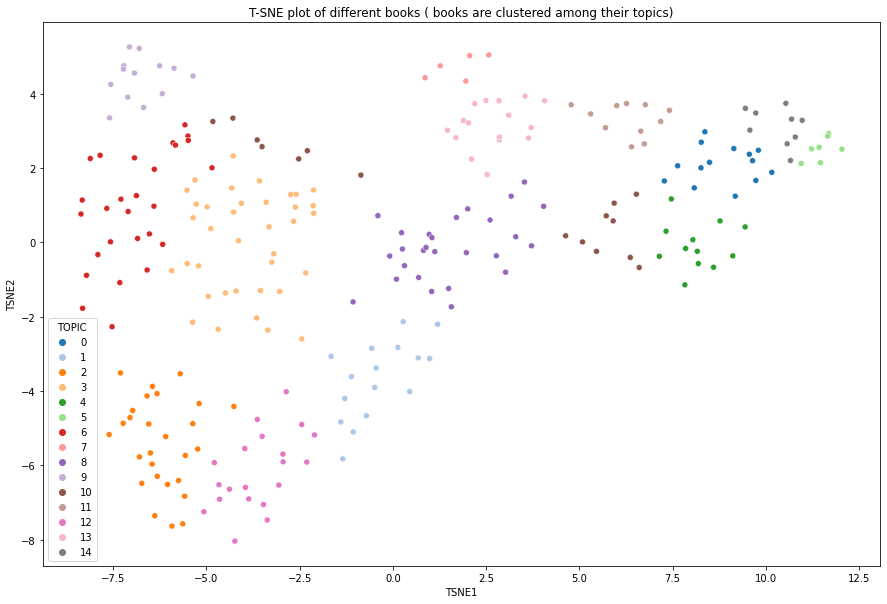

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('T-SNE plot of different books ( books are clustered among their topics)')
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='TOPIC', data=tsne_df, legend='full', palette="tab20")

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

# label_point(tsne_df['TSNE1'], tsne_df['TSNE2'], tsne_df['BOOK'], plt.gca())

plt.show()